In [24]:
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,DepthwiseConv2D,GlobalAveragePooling2D,SeparableConv2D
from tensorflow.keras.layers import BatchNormalization, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import os
from time import time
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator ,load_img
from PIL import Image
import os
import numpy as np
import random as rand
import shutil

In [64]:
with tf.device('/GPU:0'):
    batch_s = 64
    # Define paths to your train and fine-tuning directories
    train_dir = './TRAIN'
    fine_tuning_dir = './TUNE'

    # Validation data generator without augmentation
    val_data_gen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )
    val_generator = val_data_gen.flow_from_directory(
        train_dir,
        target_size=(128, 128),
        batch_size=64,
        class_mode='categorical',
        subset='validation',  # Specify that this is the validation subset
        shuffle=False,
    )

    # fine-tune generator:
    fine_tuning_gen = ImageDataGenerator(rescale=1./255)
    fine_tuning_generator = fine_tuning_gen.flow_from_directory(
        fine_tuning_dir,
        target_size=(128, 128),
        batch_size=batch_s,
        class_mode='categorical',
        shuffle=True,
        seed=42
    ) 

Found 1600 images belonging to 8 classes.
Found 1600 images belonging to 8 classes.


In [26]:
original_data_dir = './TRAIN/'  # Original images
augmented_data_dir = './TRAIN_VGG/'  # Directory to save augmented images

In [27]:
if not os.path.exists(augmented_data_dir):
    os.makedirs(augmented_data_dir)
    # ImageDataGenerator with augmentation
    data_gen_aug = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # the last 200 images of each class will be used for validation as validation_split=0.2
    NUMBER_OF_IMAGES_PER_CLASS = 800
    NUMER_OF_AUG_PER_IMAGE = 2
    Rate_of_augmentation = 4
    # Loop through each file in each subdirectory of the original data directory and augment
    for folder in os.listdir(original_data_dir):
        folder_path = os.path.join(original_data_dir, folder)
        des_folder_path = os.path.join(augmented_data_dir, folder)
        if not os.path.exists(des_folder_path):
            os.makedirs(des_folder_path)
        if os.path.isdir(folder_path):
            j = 0
            for filename in os.listdir(folder_path):
                if(j > NUMBER_OF_IMAGES_PER_CLASS):
                    break
                j += 1
                if filename.endswith(".jpg") or filename.endswith(".png"):  # check for image files
                    img_path = os.path.join(folder_path, filename)
                    img = load_img(img_path)
                    # save image:
                    img.save(os.path.join(des_folder_path, filename))
                    img_array = img_to_array(img)
                    img_array = img_array.reshape((1,) + img_array.shape)
                    # create a random number to decide whether to augment or not
                    rand_num = rand.randint(1, Rate_of_augmentation)
                    if (Rate_of_augmentation == 1):
                        continue
                    # Generate augmented images
                    i = 0
                    for batch in data_gen_aug.flow(img_array, batch_size=1, save_to_dir=des_folder_path, save_prefix='aug', save_format='jpeg'):
                        i += 1
                        if i >= NUMER_OF_AUG_PER_IMAGE:  # Number of augmented versions to create
                            break

In [28]:
with tf.device('/GPU:0'):
    batch_s = 128
    # Define paths to your train and fine-tuning directories
    train_dir = augmented_data_dir
    data_gen = ImageDataGenerator(rescale=1./255)
    # Set up the generators
    train_generator = data_gen.flow_from_directory(
    train_dir,
    target_size=(128, 128),  # Assuming you want to resize images to 128x128
    batch_size=batch_s,
    class_mode='categorical',  # Assuming a multi-class classification problem
    shuffle=True,
    seed=42  # For reproducibility
)

Found 18228 images belonging to 8 classes.


In [29]:
images, labels = next(train_generator)

/home/sepehr/anaconda3/lib/python3.11/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


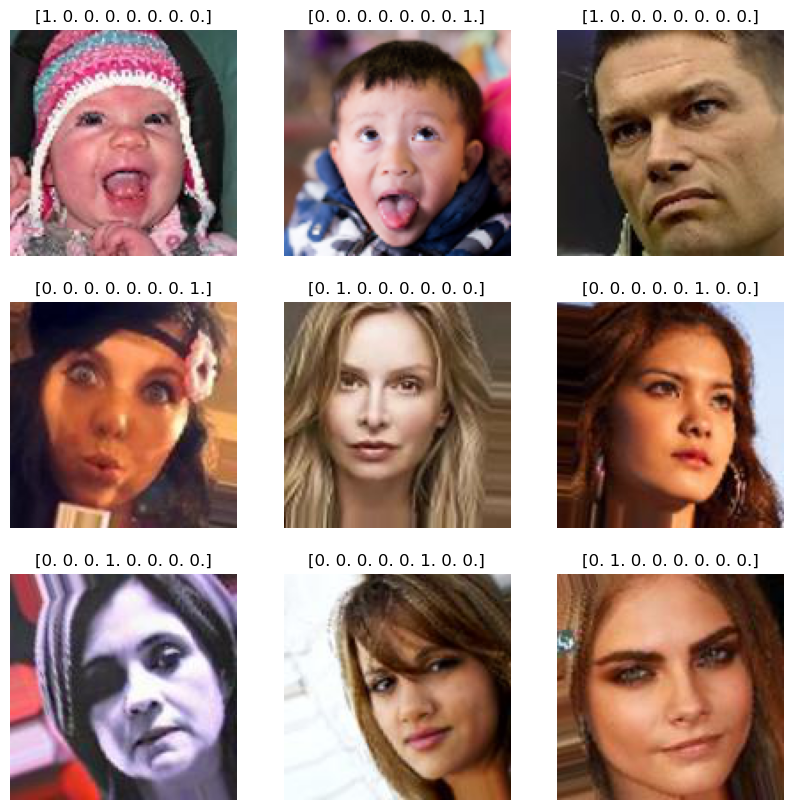

In [30]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # Display an image
    plt.imshow(images[i])
    # Add the label as the title
    plt.title(labels[i])
    plt.axis("off")

In [31]:
plt.show()
fine_tuning_generator.class_indices.keys()

dict_keys(['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])

In [32]:
print(len(train_generator.next()[0]))
train_generator.next()[1].shape

128


(128, 8)

In [33]:
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [34]:
print(get_available_gpus())

['/device:GPU:0']


2023-11-26 18:01:55.589356: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-26 18:01:55.589825: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-26 18:01:55.590127: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [35]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import DepthwiseConv2D, Conv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Dense

In [37]:
def mobilenet(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Standard Convolution Layer followed by BatchNormalization and ReLU
    x = Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = ReLU(max_value=6.)(x)

    # Depthwise Separable Convolution Blocks
    def depthwise_separable_conv_block(inputs, pointwise_filters, stride):
        # Depthwise convolution
        x = DepthwiseConv2D(kernel_size=(3, 3), strides=stride, padding='same', use_bias=False)(inputs)
        x = BatchNormalization()(x)
        x = ReLU(max_value=6.)(x)

        # Pointwise convolution
        x = Conv2D(filters=pointwise_filters, kernel_size=(1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = ReLU(max_value=6.)(x)
        
        return x

    # Apply depthwise separable convolution blocks
    x = depthwise_separable_conv_block(x, 64, stride=(1, 1))
    x = depthwise_separable_conv_block(x, 128, stride=(2, 2))
    x = depthwise_separable_conv_block(x, 128, stride=(1, 1))
    x = depthwise_separable_conv_block(x, 256, stride=(2, 2))
    x = depthwise_separable_conv_block(x, 256, stride=(1, 1))
    x = depthwise_separable_conv_block(x, 512, stride=(2, 2))

    # Usually, in the MobileNet architecture, the last depthwise separable convolution block is repeated multiple times
    # Repeat the last block as per your requirement
    x = depthwise_separable_conv_block(x, 1024, stride=(2, 2))
    x = depthwise_separable_conv_block(x, 1024, stride=(1, 1))

    # Global Average Pooling followed by a Dense layer
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(units=8, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    return model

In [38]:
input_shape = (128, 128, 3)
num_classes = 8
model = mobilenet(input_shape, num_classes)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 32)        864       
                                                                 
 batch_normalization_17 (Ba  (None, 64, 64, 32)        128       
 tchNormalization)                                               
                                                                 
 re_lu_17 (ReLU)             (None, 64, 64, 32)        0         
                                                                 
 depthwise_conv2d_8 (Depthw  (None, 64, 64, 32)        288       
 iseConv2D)                                                      
                                                                 
 batch_normalization_18 (Ba  (None, 64, 64, 32)        128 

In [39]:
with tf.device('/GPU:0'):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 32)        864       
                                                                 
 batch_normalization_17 (Ba  (None, 64, 64, 32)        128       
 tchNormalization)                                               
                                                                 
 re_lu_17 (ReLU)             (None, 64, 64, 32)        0         
                                                                 
 depthwise_conv2d_8 (Depthw  (None, 64, 64, 32)        288       
 iseConv2D)                                                      
                                                                 
 batch_normalization_18 (Ba  (None, 64, 64, 32)        128 

In [65]:
print(train_generator.samples)
print(train_generator.batch_size)
train_generator.samples // train_generator.batch_size,

18228
128


(142,)

In [66]:
# train the model
MODEL_NAME = 'mobilenet.keras'
with tf.device('/GPU:0'):
    # Assume 'model' is the instance of your Keras model
    if MODEL_NAME in os.listdir('.'):
        print("Loading model weights...")
        model.load_weights(f'./{MODEL_NAME}')
    else:
        history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=60,
        batch_size=batch_s,
        validation_data=val_generator,
        validation_steps=val_generator.samples // val_generator.batch_size,)
        # model.save_weights(MODEL_NAME)

Loading model weights...


In [67]:
# evalute after train:
with tf.device('/GPU:0'):
    results = model.evaluate(val_generator)

25/25 [==============================] - 2s 77ms/step - loss: 1.0509 - accuracy: 0.7781


In [68]:
# tune the model:
with tf.device('/GPU:0'):
    history = model.fit(
        fine_tuning_generator,
        epochs=5,
        validation_data= val_generator,
    )
    results = model.evaluate(val_generator, batch_size=batch_s)

Epoch 1/5


25/25 [==============================] - 9s 346ms/step - loss: 3.2895 - accuracy: 0.3300 - val_loss: 10.4672 - val_accuracy: 0.1331
Epoch 2/5
25/25 [==============================] - 9s 346ms/step - loss: 0.8540 - accuracy: 0.7113 - val_loss: 5.1511 - val_accuracy: 0.2644
Epoch 3/5
25/25 [==============================] - 9s 346ms/step - loss: 0.1812 - accuracy: 0.9669 - val_loss: 2.7584 - val_accuracy: 0.4013
Epoch 4/5
25/25 [==============================] - 9s 347ms/step - loss: 0.0367 - accuracy: 0.9975 - val_loss: 2.5550 - val_accuracy: 0.4100
Epoch 5/5
25/25 [==============================] - 2s 77ms/step - loss: 2.3540 - accuracy: 0.4175


In [69]:
def report(data_generator,model):
        class_labels = list(data_generator.class_indices.keys())
        num_samples = data_generator.samples
        batch_size = data_generator.batch_size
        num_classes = data_generator.num_classes
        actual_labels = data_generator.classes
        predicted_labels = model.predict(data_generator).argmax(axis=1)
        report = classification_report(actual_labels, predicted_labels, target_names=class_labels)
        print(report)
        assert len(predicted_labels) == len(actual_labels)
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(loc='upper left')
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(loc='upper right')
        plt.show()
        def plot_confusion_matrix(cm, classes,
                                normalize=False,
                                title='Confusion matrix',
                                cmap=plt.cm.Greens):
            plt.imshow(cm, interpolation='nearest', cmap=cmap)
            plt.title(title)
            plt.colorbar()
            tick_marks = np.arange(len(classes))
            plt.xticks(tick_marks, classes, rotation=45)
            plt.yticks(tick_marks, classes)
            if normalize:
                cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
                print("Normalized confusion matrix")
            else:
                print('Confusion matrix, without normalization')
            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j, i, cm[i, j],
                        horizontalalignment="center",
                        color="white" if cm[i, j] > thresh else "black")
            plt.tight_layout()
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.show()
            def generate_roc_curves(labels,y_pred,y_true):
                for (label_int,label) in enumerate(class_labels):
                    fpr, tpr, _ = roc_curve( y_true,y_pred,pos_label=label_int) 
                    roc_auc = auc(fpr, tpr)
                    plt.figure()
                    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
                    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                    plt.xlim([0.0, 1.0])
                    plt.ylim([0.0, 1.05])
                    plt.xlabel('False Positive Rate')
                    plt.ylabel('True Positive Rate')
                    plt.title('Receiver Operating Characteristic Example ' +  label)
                    plt.legend(loc="lower right")
                    plt.show()
            generate_roc_curves(class_labels,predicted_labels,actual_labels)
        plt.figure(figsize=(10,10))
        cm = confusion_matrix(actual_labels, predicted_labels)
        plot_confusion_matrix(cm, classes=class_labels)

25/25 [==============================] - 2s 75ms/step
              precision    recall  f1-score   support

       anger       0.37      0.47      0.42       200
    contempt       0.49      0.30      0.37       200
     disgust       0.42      0.12      0.18       200
        fear       0.42      0.35      0.38       200
       happy       0.72      0.62      0.67       200
     neutral       0.34      0.88      0.49       200
         sad       0.47      0.40      0.43       200
    surprise       0.29      0.20      0.23       200

    accuracy                           0.42      1600
   macro avg       0.44      0.42      0.40      1600
weighted avg       0.44      0.42      0.40      1600



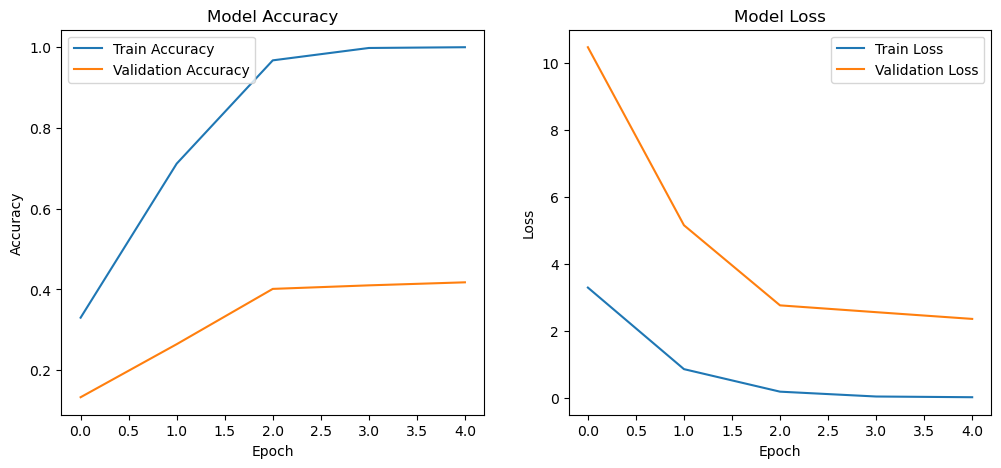

Confusion matrix, without normalization


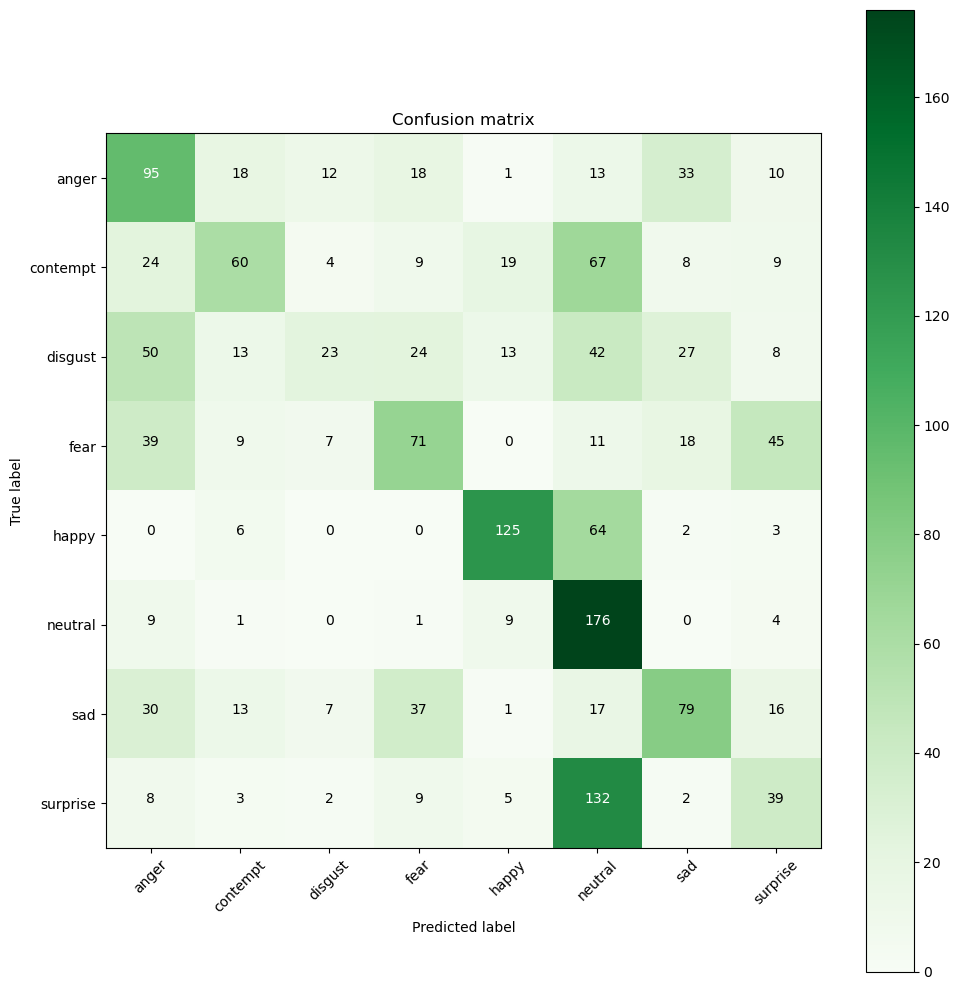

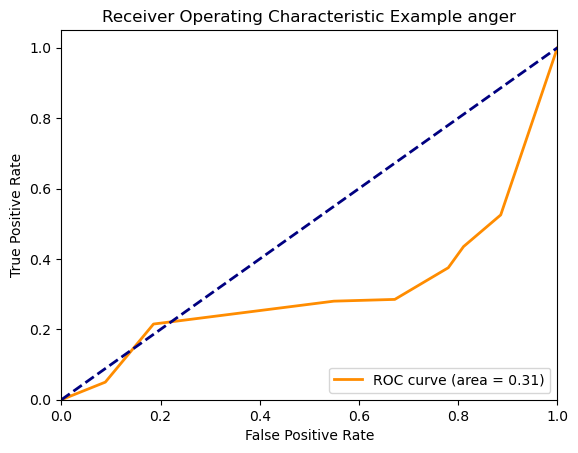

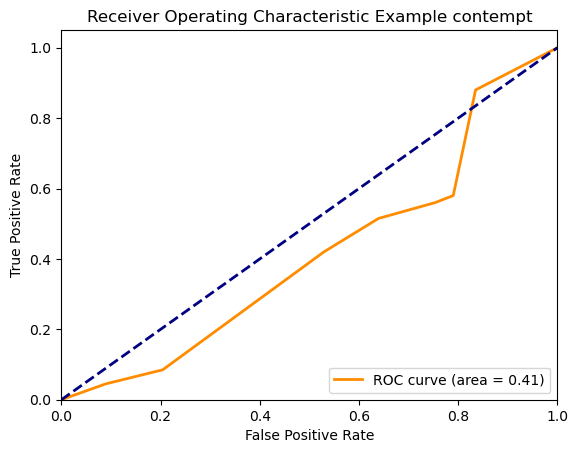

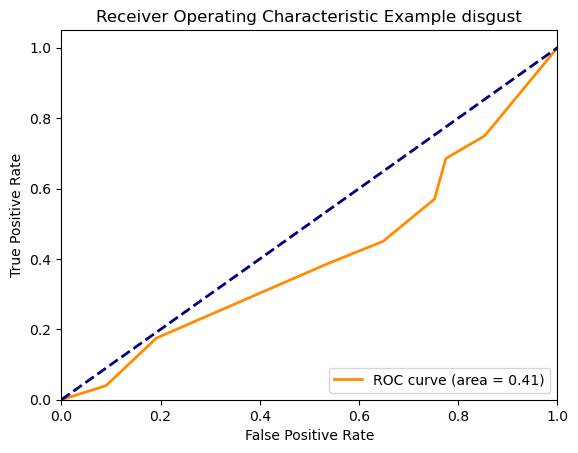

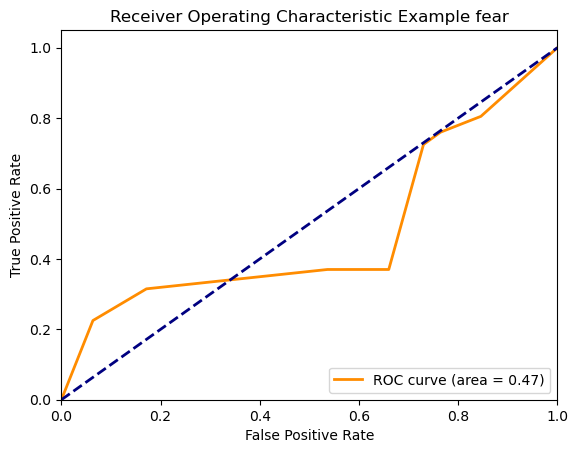

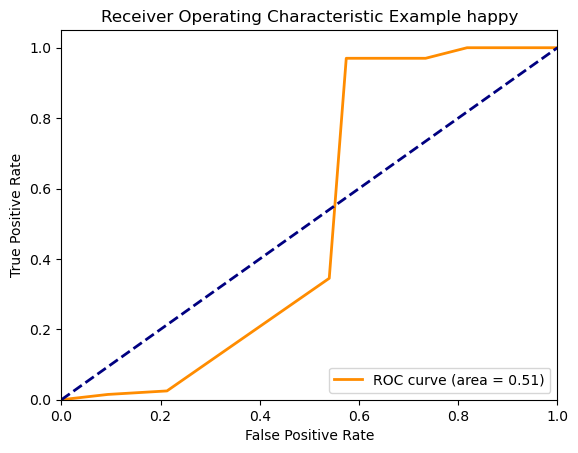

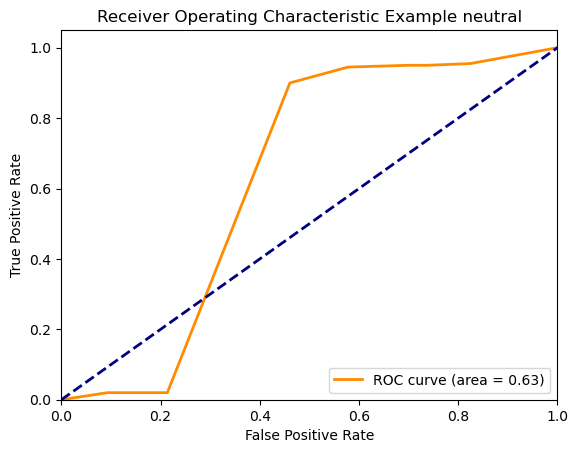

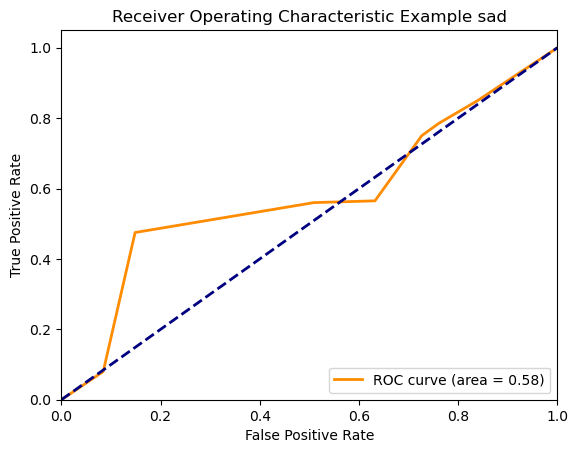

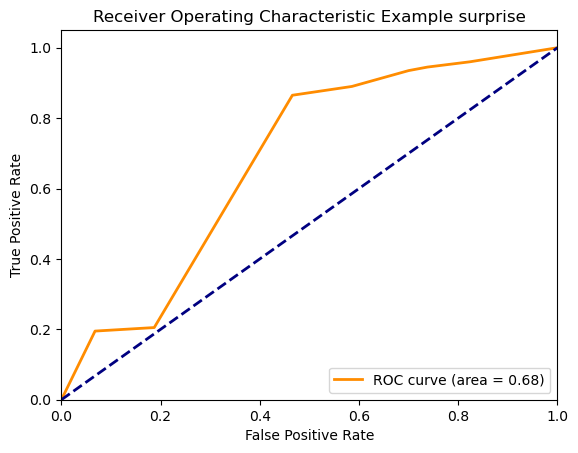

In [70]:
report(val_generator,model)
